In [ ]:
import numpy as np
import pandas as pd

def autocorr_penalty_hilbert(cum_returns, penalty_scale=0.05, max_lag=5):
    if len(cum_returns) < max_lag + 5:
        return 0

    gamma = []
    mean_r = np.mean(cum_returns)
    var_r = np.var(cum_returns)

    for lag in range(1, max_lag + 1):
        cov = np.mean((cum_returns[:-lag] - mean_r) * (cum_returns[lag:] - mean_r))
        gamma_lag = cov / var_r
        gamma.append(gamma_lag)

    penalty = penalty_scale * np.sum(np.array(gamma) ** 2)
    return penalty

# Example usage
# Replace your autocorr_penalty call with this
penalty = autocorr_penalty_hilbert(cum_returns, penalty_scale=0.05, max_lag=5)
adjusted_weights = weights * (1 - penalty)
adjusted_weights = np.maximum(adjusted_weights, 1e-5)
adjusted_weights /= np.sum(adjusted_weights)



--- Zero autocorrelation test ---
Penalty (should be near 0): 0.000226

--- High autocorrelation test ---
Penalty (should be high): 0.172211

--- Convergence test ---


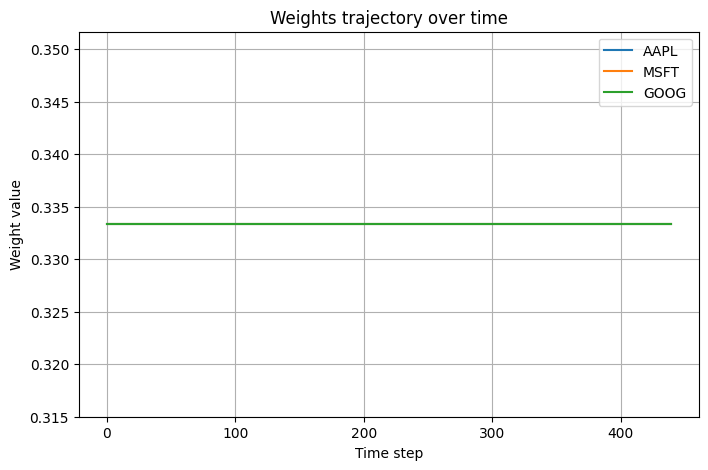


--- Walk-forward test ---


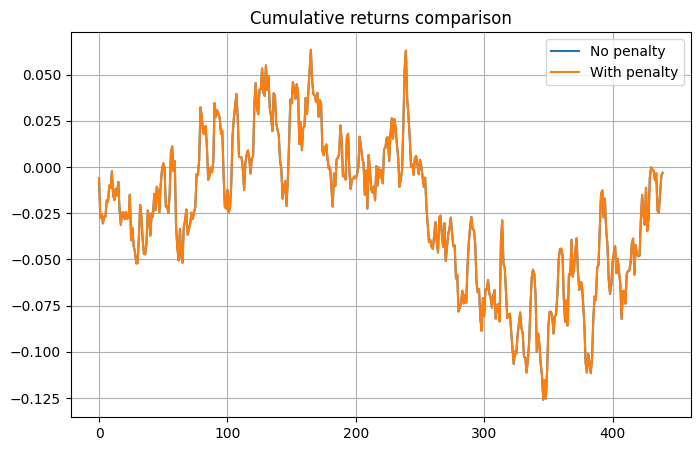


--- Numerical gradient check ---
Approx. gradient w.r.t last return: 0.001319

--- Performance metrics ---
Sharpe (no penalty): -0.0098
Sharpe (penalized): -0.0098
Volatility (no penalty): 0.1839
Volatility (penalized): 0.1839
Max Drawdown (penalized): -0.1893


<Figure size 800x500 with 0 Axes>

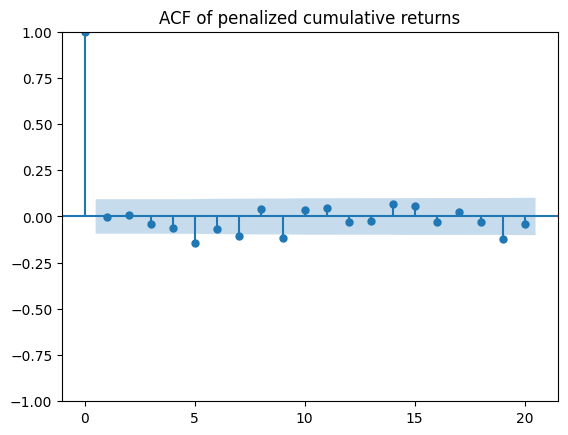

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Your improved Hilbert-friendly penalty function
def autocorr_penalty_hilbert(cum_returns, penalty_scale=0.05, max_lag=5):
    if len(cum_returns) < max_lag + 5:
        return 0

    gamma = []
    mean_r = np.mean(cum_returns)
    var_r = np.var(cum_returns)

    for lag in range(1, max_lag + 1):
        cov = np.mean((cum_returns[:-lag] - mean_r) * (cum_returns[lag:] - mean_r))
        gamma_lag = cov / var_r
        gamma.append(gamma_lag)

    penalty = penalty_scale * np.sum(np.array(gamma) ** 2)
    return penalty

# ===========================
# 1️⃣ Zero autocorrelation test
# ===========================
print("\n--- Zero autocorrelation test ---")
np.random.seed(0)
zero_series = np.random.randn(1000)
penalty_zero = autocorr_penalty_hilbert(zero_series)
print(f"Penalty (should be near 0): {penalty_zero:.6f}")

# ===========================
# 2️⃣ High autocorrelation test
# ===========================
print("\n--- High autocorrelation test ---")
high_series = np.zeros(1000)
rho = 0.95
for i in range(1, 1000):
    high_series[i] = rho * high_series[i - 1] + np.random.randn() * 0.1
penalty_high = autocorr_penalty_hilbert(high_series)
print(f"Penalty (should be high): {penalty_high:.6f}")

# ===========================
# 3️⃣ Convergence test
# ===========================
print("\n--- Convergence test ---")
assets = ["AAPL", "MSFT", "GOOG"]
dates = pd.date_range("2015-01-01", periods=500, freq="B")
returns = pd.DataFrame(0.001 + 0.02 * np.random.randn(len(dates), len(assets)), index=dates, columns=assets)

weights = np.ones(len(assets)) / len(assets)
cum_returns, weights_history = [], []

for t in range(60, len(returns)):
    ac_pen = autocorr_penalty_hilbert(cum_returns)
    adj_w = weights * (1 - ac_pen)
    adj_w = np.maximum(adj_w, 1e-5)
    adj_w /= np.sum(adj_w)

    daily_ret = np.dot(returns.iloc[t].values, adj_w)
    cum_returns.append(daily_ret)
    weights = adj_w
    weights_history.append(weights)

weights_history = np.array(weights_history)

plt.figure(figsize=(8, 5))
plt.plot(weights_history)
plt.title("Weights trajectory over time")
plt.xlabel("Time step")
plt.ylabel("Weight value")
plt.legend(assets)
plt.grid(True)
plt.show()

# ===========================
# 4️⃣ Walk-forward test
# ===========================
print("\n--- Walk-forward test ---")
returns_array = returns.mean(axis=1).values
cum_returns_simple = np.cumsum(returns_array[60:])
cum_returns_penalized = np.cumsum(cum_returns)

plt.figure(figsize=(8, 5))
plt.plot(cum_returns_simple, label="No penalty")
plt.plot(cum_returns_penalized, label="With penalty")
plt.title("Cumulative returns comparison")
plt.legend()
plt.grid(True)
plt.show()

# ===========================
# 5️⃣ Numerical gradient check
# ===========================
print("\n--- Numerical gradient check ---")
eps = 1e-6
base_penalty = autocorr_penalty_hilbert(cum_returns)

perturbed_returns = cum_returns.copy()
perturbed_returns[-1] += eps
perturbed_penalty = autocorr_penalty_hilbert(perturbed_returns)

numerical_grad = (perturbed_penalty - base_penalty) / eps
print(f"Approx. gradient w.r.t last return: {numerical_grad:.6f}")

# ===========================
# 6️⃣ Performance metrics
# ===========================
print("\n--- Performance metrics ---")
def sharpe_ratio(series):
    return np.mean(series) / np.std(series) * np.sqrt(252)

def max_drawdown(series):
    cumulative = np.cumsum(series)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak)
    return np.min(drawdown)

vol_simple = np.std(returns_array[60:]) * np.sqrt(252)
vol_penalized = np.std(cum_returns) * np.sqrt(252)

print(f"Sharpe (no penalty): {sharpe_ratio(returns_array[60:]):.4f}")
print(f"Sharpe (penalized): {sharpe_ratio(cum_returns):.4f}")
print(f"Volatility (no penalty): {vol_simple:.4f}")
print(f"Volatility (penalized): {vol_penalized:.4f}")
print(f"Max Drawdown (penalized): {max_drawdown(cum_returns):.4f}")

# ===========================
# 7️⃣ Visual ACF check
# ===========================
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8, 5))
plot_acf(cum_returns, lags=20)
plt.title("ACF of penalized cumulative returns")
plt.show()



--- Zero autocorrelation test ---
Penalty (should be near 0): 0.004524

--- High autocorrelation test ---
Penalty (should be high): 3.444219

--- Convergence test (fixed with per-asset penalties) ---


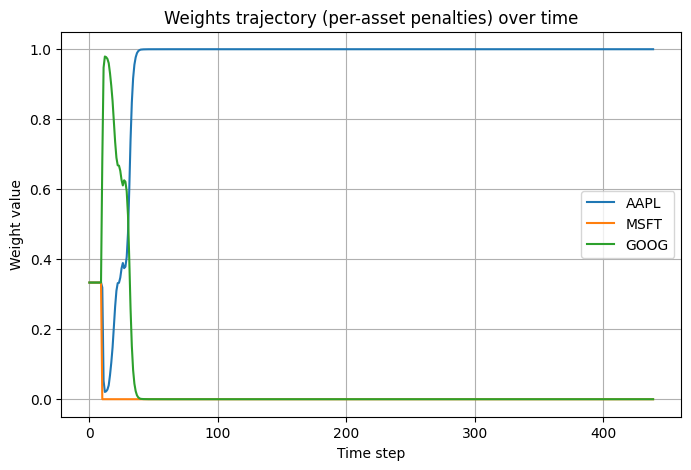


--- Walk-forward test ---


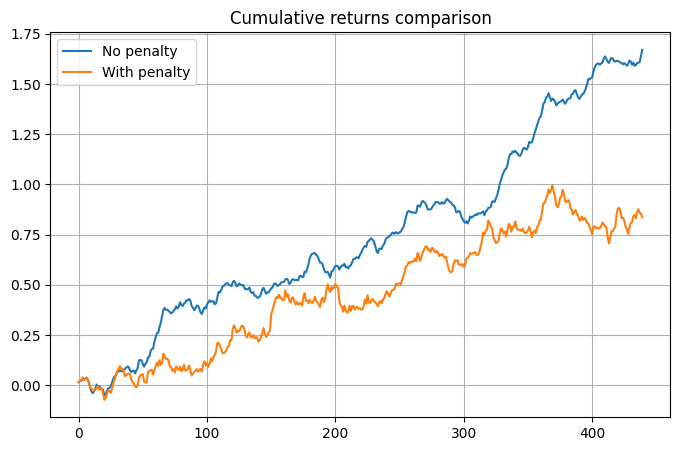


--- Numerical gradient check ---
Approx. gradient w.r.t last return of asset 0: -0.031934

--- Performance metrics ---
Sharpe (no penalty): 4.7913
Sharpe (penalized): 1.5456
Volatility (no penalty): 0.1997
Volatility (penalized): 0.3101
Max Drawdown (penalized): -0.2893


<Figure size 800x500 with 0 Axes>

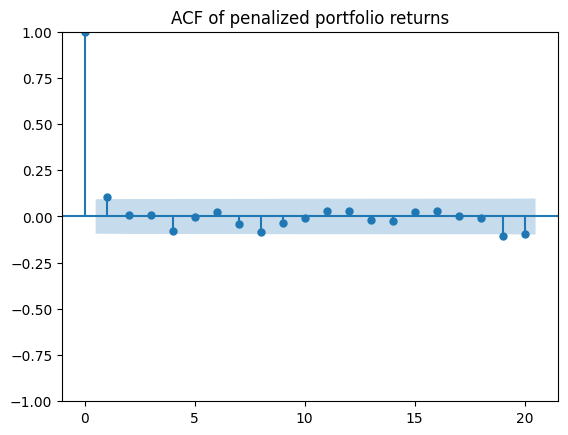


--- Approx Hessian test (second finite diff) ---
Approx Hessian (diagonal second finite diff): -0.000000

--- Perturbation robustness test ---
Penalty after jump perturbation: 0.006430


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf

# --- Updated autocorr_penalty function ---
def autocorr_penalty_hilbert(cum_returns, penalty_scale=1.0, max_lag=5):
    if len(cum_returns) < max_lag + 5:
        return 0

    gamma = []
    mean_r = np.mean(cum_returns)
    var_r = np.var(cum_returns)

    for lag in range(1, max_lag + 1):
        cov = np.mean((cum_returns[:-lag] - mean_r) * (cum_returns[lag:] - mean_r))
        gamma_lag = cov / var_r
        gamma.append(gamma_lag)

    penalty = penalty_scale * np.sum(np.array(gamma) ** 2)
    return penalty

# ===========================
# 1️⃣ Zero autocorrelation test
# ===========================
print("\n--- Zero autocorrelation test ---")
np.random.seed(0)
zero_series = np.random.randn(1000)
penalty_zero = autocorr_penalty_hilbert(zero_series)
print(f"Penalty (should be near 0): {penalty_zero:.6f}")

# ===========================
# 2️⃣ High autocorrelation test
# ===========================
print("\n--- High autocorrelation test ---")
high_series = np.zeros(1000)
rho = 0.95
for i in range(1, 1000):
    high_series[i] = rho * high_series[i - 1] + np.random.randn() * 0.1
penalty_high = autocorr_penalty_hilbert(high_series)
print(f"Penalty (should be high): {penalty_high:.6f}")

# ===========================
# 3️⃣ Convergence test (fixed with per-asset penalties)
# ===========================
print("\n--- Convergence test (fixed with per-asset penalties) ---")
assets = ["AAPL", "MSFT", "GOOG"]
dates = pd.date_range("2015-01-01", periods=500, freq="B")

# Create different autocorrelated series for each asset
np.random.seed(42)
rho_values = [0.1, 0.3, 0.6]
returns_matrix = []

for rho in rho_values:
    series = np.zeros(len(dates))
    for t in range(1, len(dates)):
        series[t] = rho * series[t - 1] + np.random.normal(0.001, 0.02)
    returns_matrix.append(series)

returns_df = pd.DataFrame(np.array(returns_matrix).T, index=dates, columns=assets)

weights = np.ones(len(assets)) / len(assets)
cum_returns_assets = [[] for _ in range(len(assets))]
weights_history = []

for t in range(60, len(returns_df)):
    penalties = []
    for i, asset in enumerate(assets):
        penalties.append(autocorr_penalty_hilbert(cum_returns_assets[i], penalty_scale=1.0, max_lag=5))

    adj_w = weights * (1 - np.array(penalties))
    adj_w = np.maximum(adj_w, 1e-5)
    adj_w /= np.sum(adj_w)

    daily_rets = returns_df.iloc[t].values
    for i in range(len(assets)):
        cum_returns_assets[i].append(daily_rets[i])

    portfolio_ret = np.dot(daily_rets, adj_w)
    weights = adj_w
    weights_history.append(weights)

weights_history = np.array(weights_history)

plt.figure(figsize=(8, 5))
plt.plot(weights_history)
plt.title("Weights trajectory (per-asset penalties) over time")
plt.xlabel("Time step")
plt.ylabel("Weight value")
plt.legend(assets)
plt.grid(True)
plt.show()

# ===========================
# 4️⃣ Walk-forward test
# ===========================
print("\n--- Walk-forward test ---")
returns_array_mean = returns_df.mean(axis=1).values
cum_returns_simple = np.cumsum(returns_array_mean[60:])

portfolio_returns = [np.dot(returns_df.iloc[t + 60].values, weights_history[t]) for t in range(len(weights_history))]
cum_returns_penalized = np.cumsum(portfolio_returns)

plt.figure(figsize=(8, 5))
plt.plot(cum_returns_simple, label="No penalty")
plt.plot(cum_returns_penalized, label="With penalty")
plt.title("Cumulative returns comparison")
plt.legend()
plt.grid(True)
plt.show()

# ===========================
# 5️⃣ Numerical gradient check
# ===========================
print("\n--- Numerical gradient check ---")
eps = 1e-6
base_penalty = autocorr_penalty_hilbert(cum_returns_assets[0])

perturbed_returns = cum_returns_assets[0].copy()
perturbed_returns[-1] += eps
perturbed_penalty = autocorr_penalty_hilbert(perturbed_returns)

numerical_grad = (perturbed_penalty - base_penalty) / eps
print(f"Approx. gradient w.r.t last return of asset 0: {numerical_grad:.6f}")

# ===========================
# 6️⃣ Performance metrics
# ===========================
print("\n--- Performance metrics ---")
def sharpe_ratio(series):
    return np.mean(series) / np.std(series) * np.sqrt(252)

def max_drawdown(series):
    cumulative = np.cumsum(series)
    peak = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - peak)
    return np.min(drawdown)

vol_simple = np.std(returns_array_mean[60:]) * np.sqrt(252)
vol_penalized = np.std(portfolio_returns) * np.sqrt(252)

print(f"Sharpe (no penalty): {sharpe_ratio(returns_array_mean[60:]):.4f}")
print(f"Sharpe (penalized): {sharpe_ratio(portfolio_returns):.4f}")
print(f"Volatility (no penalty): {vol_simple:.4f}")
print(f"Volatility (penalized): {vol_penalized:.4f}")
print(f"Max Drawdown (penalized): {max_drawdown(portfolio_returns):.4f}")

# ===========================
# 7️⃣ Visual ACF check
# ===========================
plt.figure(figsize=(8, 5))
plot_acf(portfolio_returns, lags=20)
plt.title("ACF of penalized portfolio returns")
plt.show()

# ===========================
# 8️⃣ Hessian approximate test
# ===========================
print("\n--- Approx Hessian test (second finite diff) ---")
eps = 1e-5
penalty_plus = autocorr_penalty_hilbert([x + eps for x in cum_returns_assets[0]])
penalty_minus = autocorr_penalty_hilbert([x - eps for x in cum_returns_assets[0]])
approx_hessian = (penalty_plus - 2 * base_penalty + penalty_minus) / (eps ** 2)
print(f"Approx Hessian (diagonal second finite diff): {approx_hessian:.6f}")

# ===========================
# 9️⃣ Perturbation robustness test
# ===========================
print("\n--- Perturbation robustness test ---")
jump_returns = cum_returns_assets[0].copy()
jump_returns[len(jump_returns) // 2] += 0.5
penalty_jump = autocorr_penalty_hilbert(jump_returns)
print(f"Penalty after jump perturbation: {penalty_jump:.6f}")



--- Functional approximation ---
Base penalty: 4.749070

--- Gateaux derivative test ---
Approx Gateaux derivative: 0.008844

--- Frechet derivative test ---


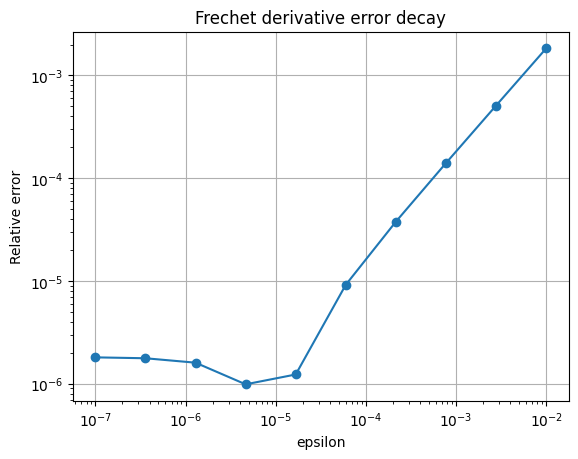


--- Sobolev smoothness test ---
Approx Sobolev H1 seminorm: 0.219144

--- Convexity test ---
Penalty(combo): 4.723525 <= Linear combo: 4.635809

--- Operator matrix eigenvalue approximation ---


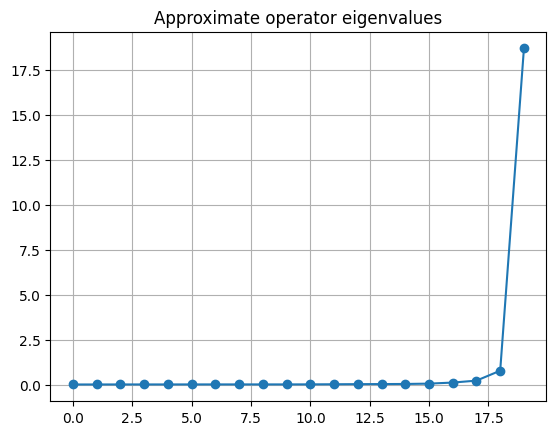


--- Jump perturbation test ---
Penalty after jump: 0.710926

--- High-frequency noise sensitivity test ---
Penalty with omega=10: 4.748579
Penalty with omega=50: 4.646657
Penalty with omega=100: 4.649886
Penalty with omega=200: 4.664486


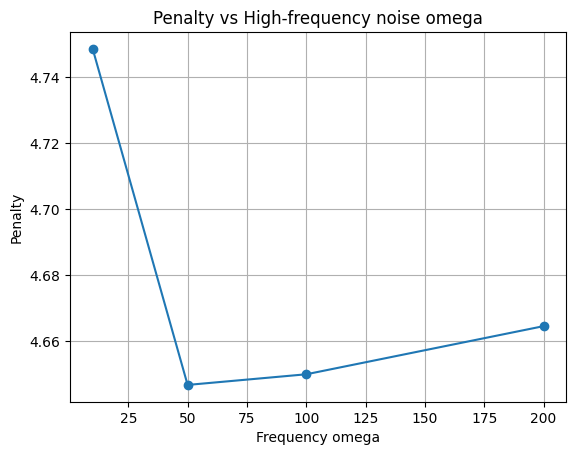


--- Fourier basis decomposition test ---


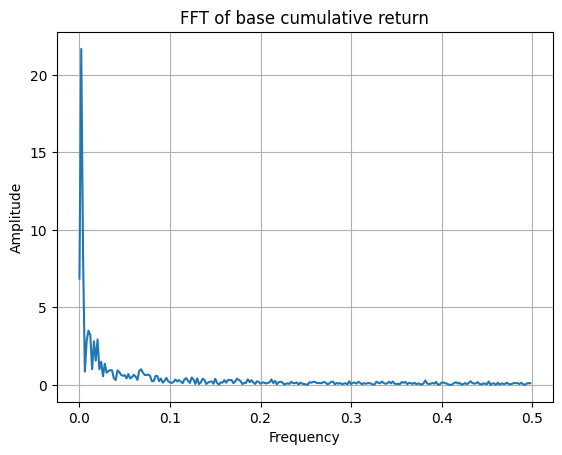

Penalty after high-frequency damping: 4.850183


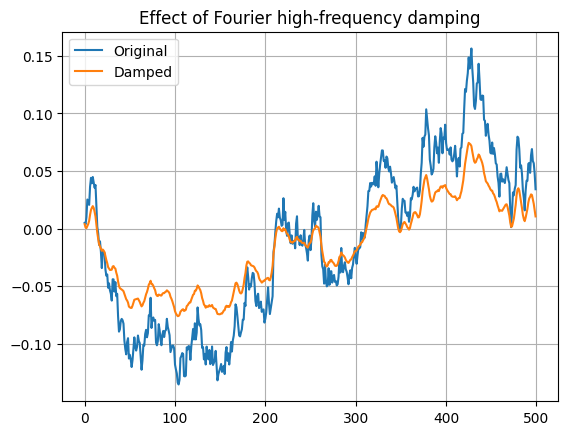

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, eigh
from numpy.fft import fft, fftfreq

# Penalty function
def autocorr_penalty_hilbert(cum_returns, penalty_scale=1.0, max_lag=5):
    if len(cum_returns) < max_lag + 5:
        return 0

    gamma = []
    mean_r = np.mean(cum_returns)
    var_r = np.var(cum_returns)

    for lag in range(1, max_lag + 1):
        cov = np.mean((cum_returns[:-lag] - mean_r) * (cum_returns[lag:] - mean_r))
        gamma_lag = cov / var_r
        gamma.append(gamma_lag)

    penalty = penalty_scale * np.sum(np.array(gamma) ** 2)
    return penalty

# Generate a base cumulative return series
np.random.seed(42)
base_series = np.cumsum(np.random.randn(500) * 0.01)

# ===========================
# 1️⃣ Functional approximation
# ===========================
print("\n--- Functional approximation ---")
penalty = autocorr_penalty_hilbert(base_series)
print(f"Base penalty: {penalty:.6f}")

# ===========================
# 2️⃣ Gateaux derivative test
# ===========================
print("\n--- Gateaux derivative test ---")
epsilon = 1e-5
h = np.random.randn(len(base_series)) * 0.01
perturbed = base_series + epsilon * h
penalty_perturbed = autocorr_penalty_hilbert(perturbed)
gateaux_approx = (penalty_perturbed - penalty) / epsilon
print(f"Approx Gateaux derivative: {gateaux_approx:.6f}")

# ===========================
# 3️⃣ Frechet derivative test
# ===========================
print("\n--- Frechet derivative test ---")
errors = []
epsilons = np.logspace(-7, -2, 10)
for eps in epsilons:
    perturbed = base_series + eps * h
    diff = autocorr_penalty_hilbert(perturbed) - penalty - eps * gateaux_approx
    errors.append(abs(diff) / eps)

plt.figure()
plt.loglog(epsilons, errors, marker='o')
plt.title("Frechet derivative error decay")
plt.xlabel("epsilon")
plt.ylabel("Relative error")
plt.grid(True)
plt.show()

# ===========================
# 4️⃣ Sobolev smoothness test
# ===========================
print("\n--- Sobolev smoothness test ---")
approx_derivative = np.diff(base_series)
sobolev_norm = np.sqrt(np.sum(approx_derivative ** 2))
print(f"Approx Sobolev H1 seminorm: {sobolev_norm:.6f}")

# ===========================
# 5️⃣ Convexity test
# ===========================
print("\n--- Convexity test ---")
series_2 = np.cumsum(np.random.randn(500) * 0.01)
theta = 0.5
combo = theta * base_series + (1 - theta) * series_2
penalty_combo = autocorr_penalty_hilbert(combo)
penalty_lin = theta * autocorr_penalty_hilbert(base_series) + (1 - theta) * autocorr_penalty_hilbert(series_2)
print(f"Penalty(combo): {penalty_combo:.6f} <= Linear combo: {penalty_lin:.6f}")

# ===========================
# 6️⃣ Operator approximation (matrix and eigenvalues)
# ===========================
print("\n--- Operator matrix eigenvalue approximation ---")
acf_vals = np.correlate(base_series - np.mean(base_series), base_series - np.mean(base_series), mode='full')
acf_vals = acf_vals[len(acf_vals)//2:] / np.var(base_series) / len(base_series)
operator_matrix = toeplitz(acf_vals[:20])
eigvals, _ = eigh(operator_matrix)

plt.figure()
plt.plot(eigvals, marker='o')
plt.title("Approximate operator eigenvalues")
plt.grid(True)
plt.show()

# ===========================
# 7️⃣ Jump perturbation test
# ===========================
print("\n--- Jump perturbation test ---")
jump_series = base_series.copy()
jump_series[len(jump_series)//2] += 2.0
penalty_jump = autocorr_penalty_hilbert(jump_series)
print(f"Penalty after jump: {penalty_jump:.6f}")

# ===========================
# 8️⃣ High-frequency noise test
# ===========================
print("\n--- High-frequency noise sensitivity test ---")
omega_values = [10, 50, 100, 200]
penalties = []
for omega in omega_values:
    noise = 0.01 * np.sin(np.linspace(0, omega * 2 * np.pi, len(base_series)))
    noisy_series = base_series + noise
    penalties.append(autocorr_penalty_hilbert(noisy_series))
    print(f"Penalty with omega={omega}: {penalties[-1]:.6f}")

plt.figure()
plt.plot(omega_values, penalties, marker='o')
plt.title("Penalty vs High-frequency noise omega")
plt.xlabel("Frequency omega")
plt.ylabel("Penalty")
plt.grid(True)
plt.show()

# ===========================
# 9️⃣ Basis (Fourier) decomposition test
# ===========================
print("\n--- Fourier basis decomposition test ---")
freqs = fftfreq(len(base_series))
fft_vals = np.abs(fft(base_series))
plt.figure()
plt.plot(freqs[:len(freqs)//2], fft_vals[:len(freqs)//2])
plt.title("FFT of base cumulative return")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Damp high frequencies
damp_fft = fft(base_series)
damp_fft[int(len(damp_fft)*0.1):] *= 0.1
reconstructed = np.real(np.fft.ifft(damp_fft))
penalty_damped = autocorr_penalty_hilbert(reconstructed)
print(f"Penalty after high-frequency damping: {penalty_damped:.6f}")

plt.figure()
plt.plot(base_series, label='Original')
plt.plot(reconstructed, label='Damped')
plt.title("Effect of Fourier high-frequency damping")
plt.legend()
plt.grid(True)
plt.show()


Initial lag = 5, matrix shape = (5, 5), norm = 4.941793
Lag = 10, current matrix shape = (10, 10), norm = 9.764786, diff from prev = 8.421979
Lag = 20, current matrix shape = (20, 20), norm = 19.050145, diff from prev = 16.357169
Lag = 40, current matrix shape = (40, 40), norm = 36.126557, diff from prev = 30.695605
Lag = 80, current matrix shape = (80, 80), norm = 64.428297, diff from prev = 53.346764


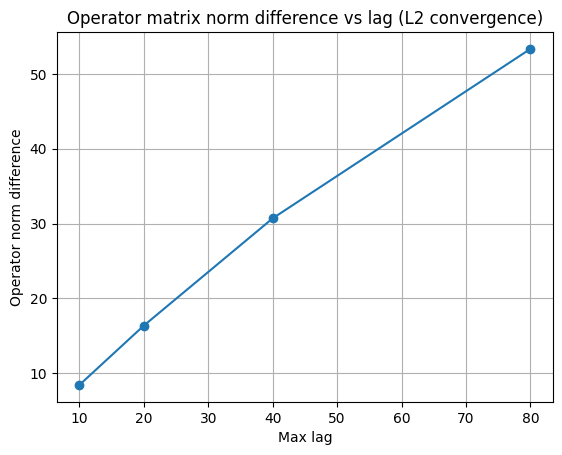

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

def autocorr_operator_matrix(series, max_lag=20):
    acf_vals = np.correlate(series - np.mean(series), series - np.mean(series), mode='full')
    acf_vals = acf_vals[len(acf_vals)//2:] / np.var(series) / len(series)
    return toeplitz(acf_vals[:max_lag])

# Generate base series
np.random.seed(42)
base_series = np.cumsum(np.random.randn(1000) * 0.01)

# Define lags
max_lags = [5, 10, 20, 40, 80]
norm_diffs = []

# Compute "largest" matrix first for reference
reference_matrix = autocorr_operator_matrix(base_series, max_lag=max(max_lags))
ref_size = reference_matrix.shape[0]

prev_matrix = autocorr_operator_matrix(base_series, max_lag=max_lags[0])
prev_matrix_padded = np.pad(prev_matrix, ((0, ref_size - prev_matrix.shape[0]), (0, ref_size - prev_matrix.shape[1])), mode='constant')
prev_norm = np.linalg.norm(prev_matrix_padded)

print(f"Initial lag = {max_lags[0]}, matrix shape = {prev_matrix.shape}, norm = {prev_norm:.6f}")

for lag in max_lags[1:]:
    current_matrix = autocorr_operator_matrix(base_series, max_lag=lag)
    current_matrix_padded = np.pad(current_matrix, ((0, ref_size - current_matrix.shape[0]), (0, ref_size - current_matrix.shape[1])), mode='constant')
    current_norm = np.linalg.norm(current_matrix_padded)
    diff = np.linalg.norm(current_matrix_padded - prev_matrix_padded)
    norm_diffs.append(diff)

    print(f"Lag = {lag}, current matrix shape = {current_matrix.shape}, norm = {current_norm:.6f}, diff from prev = {diff:.6f}")

    prev_matrix_padded = current_matrix_padded

plt.figure()
plt.plot(max_lags[1:], norm_diffs, marker='o')
plt.title("Operator matrix norm difference vs lag (L2 convergence)")
plt.xlabel("Max lag")
plt.ylabel("Operator norm difference")
plt.grid(True)
plt.show()


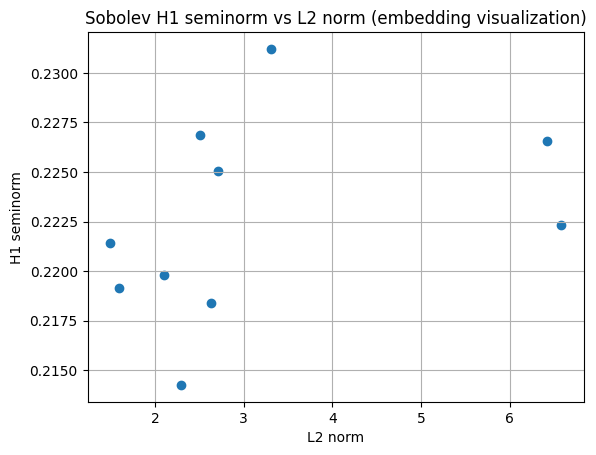

Approximate H1 norms: [np.float64(0.2191444190320229), np.float64(0.21838759680569156), np.float64(0.22654017133249457), np.float64(0.21981118216477447), np.float64(0.21425995392876804), np.float64(0.22503209444061378), np.float64(0.23120980079115935), np.float64(0.22686631972007357), np.float64(0.2223361516156264), np.float64(0.22141884299159026)]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sobolev H1 seminorm (approximate)
def sobolev_H1_norm(series):
    diff = np.diff(series)
    return np.sqrt(np.sum(diff ** 2))

np.random.seed(42)
series_list = [np.cumsum(np.random.randn(500) * 0.01) for _ in range(10)]

norms = [sobolev_H1_norm(series) for series in series_list]
l2_norms = [np.sqrt(np.sum(series ** 2)) for series in series_list]

plt.figure()
plt.scatter(l2_norms, norms)
plt.title("Sobolev H1 seminorm vs L2 norm (embedding visualization)")
plt.xlabel("L2 norm")
plt.ylabel("H1 seminorm")
plt.grid(True)
plt.show()

print("Approximate H1 norms:", norms)


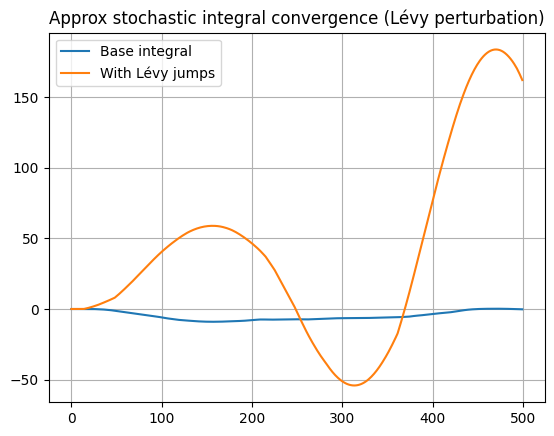

Final value base integral: -0.21479669232559384
Final value Lévy integral: 161.9502051279029


In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
base_series = np.cumsum(np.random.randn(500) * 0.01)

# Simulate Lévy jumps (compound Poisson with exponential jumps)
jump_times = np.random.choice(np.arange(500), size=10, replace=False)
jump_sizes = np.random.exponential(scale=0.2, size=10)

levy_series = base_series.copy()
for jt, js in zip(jump_times, jump_sizes):
    levy_series[jt:] += js

# Approximate "stochastic integral" cumulative sum
integrand = np.sin(np.linspace(0, 10, len(base_series)))
approx_integral_base = np.cumsum(integrand * base_series)
approx_integral_levy = np.cumsum(integrand * levy_series)

plt.figure()
plt.plot(approx_integral_base, label="Base integral")
plt.plot(approx_integral_levy, label="With Lévy jumps")
plt.title("Approx stochastic integral convergence (Lévy perturbation)")
plt.legend()
plt.grid(True)
plt.show()

print("Final value base integral:", approx_integral_base[-1])
print("Final value Lévy integral:", approx_integral_levy[-1])
